# Intro. ML Final Project

By Dave Lu, Alina Chen, Jin Rong Song

In [1]:
import pandas as pd
import numpy as np
import torch

Loading the data into Numpy arrays.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/daveylu/10315-project/main/data.csv")

X = data[["Variance", "Skewness", "Curtosis", "Entropy"]]
y = data["Class"]

X = X.to_numpy()
y = y.to_numpy()

# Random Forest Classifier

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

N = X_test.shape[0]

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
loss = log_loss(y_test, y_pred_proba)
accuracy = np.sum(y_test == y_pred) / N

print(f"Validation Cross-Entropy Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Validation Cross-Entropy Loss: 0.021629275252306582
Validation Accuracy: 0.9963636363636363


# Neural Network

Creation of PyTorch dataset

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split

X_copy = np.copy(X)
y_copy = np.copy(y)

class BankNotesDataset(Dataset):

    def __init__(self):
        self.data = torch.tensor(X_copy, dtype = torch.float32)
        self.labels = torch.tensor(y_copy, dtype = torch.float32)

    def __len__(self):
        return X.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    
train_dataset, test_dataset = random_split(BankNotesDataset(), [0.8, 0.2])

train_DL = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_DL = DataLoader(test_dataset, batch_size = 16, shuffle = True)

Creation of PyTorch Neural Net

In [5]:
import torch.nn as nn

input_dim = X.shape[1]

class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.hidden_layer_1 = nn.Linear(in_features = input_dim, out_features = input_dim)
        self.relu = nn.ReLU()
        self.hidden_layer_2 = nn.Linear(in_features = input_dim, out_features = 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        output_1 = self.hidden_layer_1(x)
        output_2 = self.relu(output_1)
        output_3 = self.hidden_layer_2(output_2)
        y_pred = self.final_activation(output_3)

        return y_pred
    
model = NeuralNet()

Creation of Training Loop (~~stolen~~ borrowed from HW7)

In [6]:
loss_fn = torch.nn.BCELoss()
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def evaluate_DL(model, dl, loss_fn):
    model = model.to(device)
    
    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for X, y in dl:
            X = X.to(device)
            y = torch.reshape(y, (-1, 1))
            y = y.to(device)

            yhat = model(X)

            lossSum += loss_fn(yhat, y) * X.shape[0]

            predictions = torch.where(yhat > 0.5, 1, 0)
            truth = torch.where(y > 0.5, 1, 0)
            nCorrect += torch.sum(predictions == truth)

        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(), acc.item()

def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evaluate_DL(model, trainDL, lossfn)
    validLoss, validAcc = evaluate_DL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc

def train(model, trainDL, validDL, loss_fn, opt, epochs = 10):
    trainLosses = []
    trainAccs   = []
    validLosses = []
    validAccs   = []

    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, loss_fn)
    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)
    validLosses.append(validLoss)
    validAccs.append(validAcc)

    model = model.to(device)
    for e in range(epochs):
        for X, y in trainDL:
            X = X.to(device)
            y = torch.reshape(y, (-1, 1))
            y = y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

        trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, loss_fn)
        trainLosses.append(trainLoss)
        trainAccs.append(trainAcc)
        validLosses.append(validLoss)
        validAccs.append(validAcc)

    return model, trainLosses, trainAccs, validLosses, validAccs

Creation of Plotting Code (~~stolen~~ borrowed from HW7)

In [7]:
import matplotlib.pyplot as plt

def plot_statistics(epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs+1)
    
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title("Cross-Entropy Loss per Epoch")
    axis.grid()
    axis.legend()
    
    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.set_title("Accuracy per Epoch")
    axis.grid()
    axis.legend()    

Training the Neural Net and Plotting Results

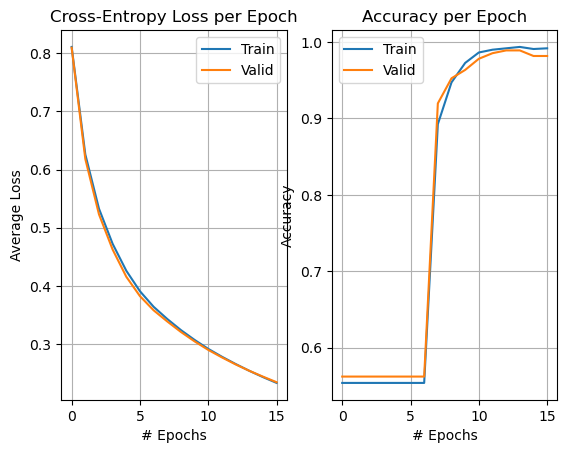

In [8]:
epochs = 15

model, trainLosses, trainAccs, validLosses, validAccs = train(model, train_DL, test_DL, loss_fn, optimizer, epochs = epochs)

plot_statistics(epochs, trainLosses, trainAccs, validLosses, validAccs)

In [9]:
print(f"Validation Cross-Entropy Loss: {validLosses[-1]}")
print(f"Validation Accuracy: {validAccs[-1]}")

Validation Cross-Entropy Loss: 0.23435191810131073
Validation Accuracy: 0.9817517995834351
